## First Exploration Notebook 

In [60]:
import numpy as np
import pandas as pd
import pysurvival
from pysurvival.models.simulations import SimulationModel
from notebook_utils import eval_object
from pysurvival.utils.display import display_baseline_simulations

import sys
sys.path.insert(1, '../auton-survival/')
from auton_survival import DeepCoxPH

import warnings
warnings.filterwarnings('ignore')
%pylab inline


Populating the interactive namespace from numpy and matplotlib


## Preliminaries

In this Notebook I compare model performance on simulated survival data of four models:
- Cox-Regression
- Random Survival Forest
- CoxPH (Deep Surv) as implemented by the Auton Lab
- A BNN created from the CoxPH model with the Bayesian-Torch library

Notes on the models:
- Right now the CoxPH model splits up some validation data (0.15) from the training data, the other models
  train on the complete training data.
- I have only created the "train" step for the BNN right now and not the "test step", I need to read a bit            more to be able to do this correctly in bayesian-torch with the partial likelihood.  

Notes on the simulated data:
- I simulated data from the different risk models (the part of the prop model that only depends on the   
  covariates):
     - Linear: $r(x) = e^{\beta * x}$
     - Gaussian: $r(x) = e^{e^{-(\beta * x)^{2} * riskparam}}$
     - Squared: $r(x) = e^{riskparam * (\beta * x)^{2}}$
- I vary the degrees of censoring. Generally the censoring distribution is a normal with mean at the censored parameter that is given in the simulation function.

- The "number of events" displayed after the simulation is the number of not censored data points.

- I change the survival distribution sometimes, but it is not particularly relevant for risk estimation under proportional hazard. I do plot it so that one gets an idea of the data and censoring relationship.

- I included one experiment in the end with multiple variables

Metric:

- I used the concordance index to compare the models. To summarise: 0.5 is random and higher is better ;)
    - It seems to be widely used and should do the job for now. In case I work more on this I can start to include       additional metrics. 

Results:

- Linear Model: Cox Regression + NN + BNN usually outperform trees
- Gaussian Model: RSF + NN + BNN outperform Cox Regression
    - Trees are overfitting a lot - maybe this could be handled with a validation set
    - None of the estimators seems to do particularly well on this dataset 
- Squared Model: NNs + BNNs outperform RSF and Cox regression
    - Neural Networks seem to do much better than the other models
    - I included one simulation without any censored data points to show that the function is learnable

Additional Notes: 

- I  haven't done anything with uncertainty yet, while I am able to get things like "predictive 
  entropy" from the BNN I am not entirely sure what they mean yet and will take the rest of the week to 
  read up on this

## Model Evaluation with Linear Hazard Function

In [75]:

# Initializing the simulation model
lin_sim = SimulationModel(survival_distribution = 'exponential',
                       risk_type = 'linear',
                       censored_parameter = 100.0,
                       risk_parameter = 100,
                       alpha = 0.01,
                       beta = 5., )
N = 1000
linear_data_train=lin_sim.generate_data(num_samples = N, num_features=2).astype(float32)
linear_data_test=lin_sim.generate_data(num_samples = int(0.2*N), num_features=2).astype(float32)

Number of data-points: 1000 - Number of events: 615.0
Number of data-points: 200 - Number of events: 110.0


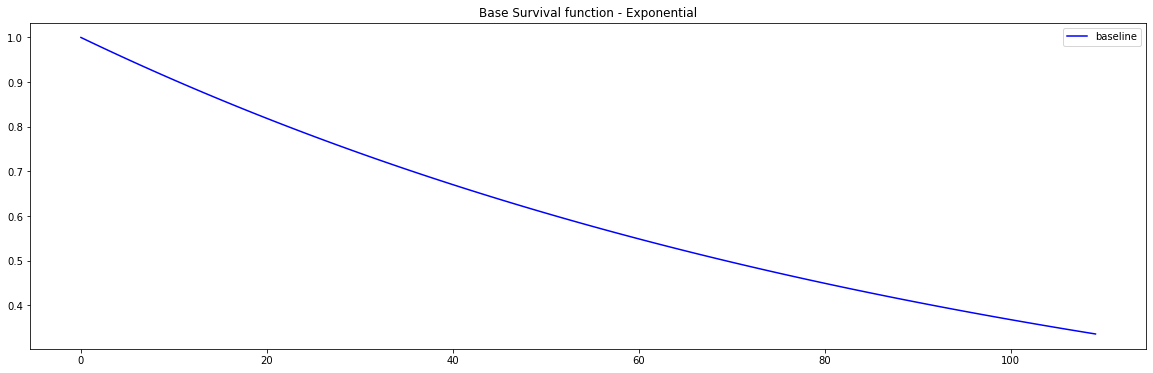

In [76]:
display_baseline_simulations(lin_sim, figure_size=(20, 6))

In [77]:
lin_data = eval_object(linear_data_train,linear_data_test,"lin")
lin_data.standscale_columns()
lin_data.fit_all_models()
lin_data.get_metrics()


100%|██████████| 50/50 [00:00<00:00, 153.21it/s]


,train_conc,test_conc
lin_coxph,0.784144,0.811623
lin_rsf,0.870393,0.779359
lin_deepcox,0.783755,0.812004
lin_deepbnn,0.783295,0.810352


## Model evaluation with Gaussian Hazard Function

In [57]:
gau_sim = SimulationModel(survival_distribution = 'Log-Normal',
                       risk_type = 'gaussian',risk_parameter = 10,
                       censored_parameter = 5.0)

N= 2000

gaussian_data_train = gau_sim.generate_data(num_samples = N, num_features=2).astype("float32")
gaussian_data_test = gau_sim.generate_data(num_samples = int(0.2*N), num_features=2).astype("float32")


Number of data-points: 2000 - Number of events: 1461.0
Number of data-points: 400 - Number of events: 284.0


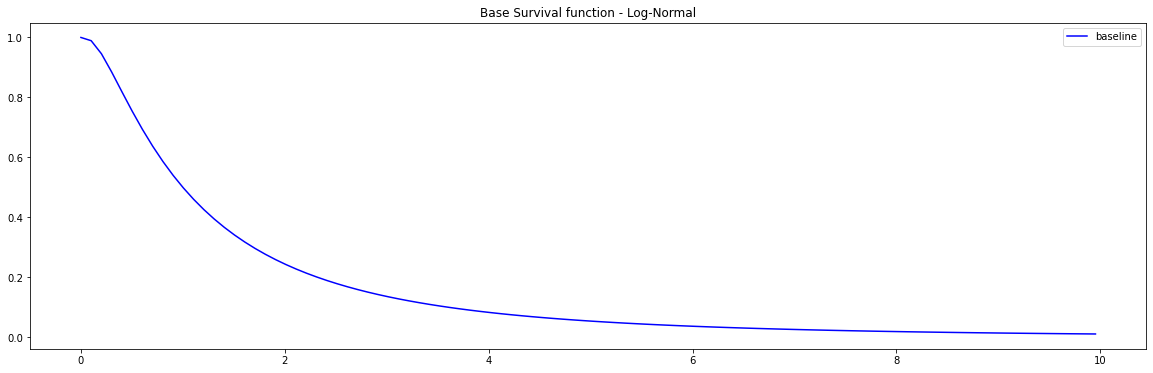

In [58]:
display_baseline_simulations(gau_sim, figure_size=(20, 6))

In [59]:
gau_data = eval_object(gaussian_data_train,gaussian_data_test,"gau")
gau_data.standscale_columns()
gau_data.fit_all_models()
gau_data.get_metrics()

 74%|███████▍  | 37/50 [00:00<00:00, 75.68it/s]


,train_conc,test_conc
gau_coxph,0.523342,0.532841
gau_rsf,0.765924,0.595032
gau_deepcox,0.555656,0.565416
gau_deepbnn,0.566312,0.600931


## Model evaluation with squared Hazard Function

In [90]:
sq_sim = SimulationModel(survival_distribution = 'exponential',
                       risk_type = 'square',
                       censored_parameter = 100.0,
                       risk_parameter = 100)

sq_sim_cen = SimulationModel(survival_distribution = 'exponential',
                       risk_type = 'square',
                       censored_parameter = 1,
                       risk_parameter = 10)
N = 2000

sq_data_train = sq_sim.generate_data(num_samples = N, num_features=2).astype("float32")
sq_data_test = sq_sim.generate_data(num_samples = int(0.4*N), num_features=2).astype("float32")


sq_data_train_cen = sq_sim_cen.generate_data(num_samples = N, num_features=2).astype("float32")
sq_data_test_cen = sq_sim_cen.generate_data(num_samples = int(0.4*N), num_features=2).astype("float32")



Number of data-points: 2000 - Number of events: 2000.0
Number of data-points: 800 - Number of events: 800.0
Number of data-points: 2000 - Number of events: 1186.0
Number of data-points: 800 - Number of events: 476.0


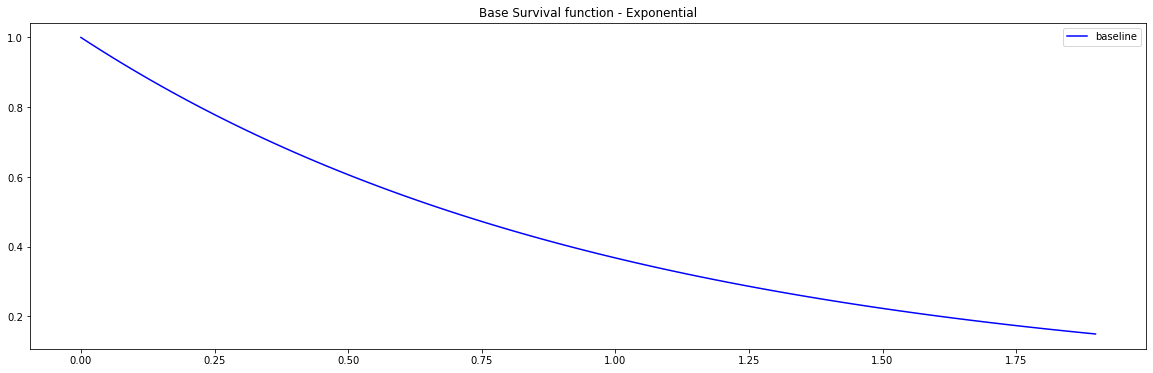

In [91]:
display_baseline_simulations(sq_sim, figure_size=(20, 6))

In [92]:
sq_data = eval_object(sq_data_train,sq_data_test,"sq")
sq_data.standscale_columns()
sq_data.fit_all_models()
sq_data.get_metrics()

 46%|████▌     | 23/50 [00:00<00:00, 74.82it/s]


,train_conc,test_conc
sq_coxph,0.508876,0.587805
sq_rsf,0.496356,0.392857
sq_deepcox,0.962595,0.958199
sq_deepbnn,0.891790,0.843628


In [93]:
sq_data_cen = eval_object(sq_data_train,sq_data_test,"sq")
sq_data_cen.standscale_columns()
sq_data_cen.fit_all_models()
sq_data_cen.get_metrics()

 46%|████▌     | 23/50 [00:00<00:00, 74.50it/s]


,train_conc,test_conc
sq_coxph,0.508876,0.587805
sq_rsf,0.513094,0.441657
sq_deepcox,0.946935,0.940986
sq_deepbnn,0.891790,0.843628


### Model with Multiple Variable and Squared Hazard

In [94]:
sq_sim_mult_cen = SimulationModel(survival_distribution = 'exponential',
                       risk_type = 'square',
                       censored_parameter = 0.1,
                       risk_parameter = 10)
N = 2000

sqmult_data_train = sq_sim_mult_cen.generate_data(num_samples = N, num_features=7).astype("float32")
sqmult_data_test = sq_sim_mult_cen.generate_data(num_samples = int(0.4*N), num_features=7).astype("float32")

Number of data-points: 2000 - Number of events: 1332.0
Number of data-points: 800 - Number of events: 550.0


In [95]:
sq_mult_cen = eval_object(sqmult_data_train,sqmult_data_test,"sq_mult")
sq_mult_cen.standscale_columns()
sq_mult_cen.fit_all_models()
sq_mult_cen.get_metrics()

 48%|████▊     | 24/50 [00:00<00:00, 68.36it/s]


,train_conc,test_conc
sq_mult_coxph,0.565534,0.479439
sq_mult_rsf,0.900277,0.671411
sq_mult_deepcox,0.871472,0.815396
sq_mult_deepbnn,0.879600,0.884156
